In [2]:
# Cell 1: Import libraries
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.losses import mse
import tensorflow.keras.backend as K
from sklearn.preprocessing import MinMaxScaler

# Load and preprocess the data
file_path = r'C:\Users\TanMeh\Desktop\jupyter\to code - Copy - 2.xlsx'
data = pd.read_excel(file_path, sheet_name='Sheet1')
print("Data loaded successfully.")


Data loaded successfully.


In [3]:
# Cell 2: Scale numerical columns
scalers = {}
preprocessed_data = data.copy()

for col in data.columns:
    if pd.api.types.is_numeric_dtype(data[col]):
        scaler = MinMaxScaler()
        preprocessed_data[[col]] = scaler.fit_transform(data[[col]])
        scalers[col] = scaler  # Save scaler for later inverse transformation

preprocessed_data = preprocessed_data.values
print("Data preprocessed successfully.")


Data preprocessed successfully.


In [4]:
# Cell 3: Define Encoder and Decoder models

# Model dimensions
original_dim = preprocessed_data.shape[1]
latent_dim = 2
intermediate_dim = 64

# Encoder
inputs = Input(shape=(original_dim,), name="encoder_input")
h = Dense(intermediate_dim, activation="relu")(inputs)
z_mean = Dense(latent_dim, name="z_mean")(h)
z_log_var = Dense(latent_dim, name="z_log_var")(h)

def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=K.shape(z_mean))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

z = Lambda(sampling, output_shape=(latent_dim,), name="z")([z_mean, z_log_var])
encoder = Model(inputs, [z_mean, z_log_var, z], name="encoder")
print("Encoder model defined.")

# Decoder
decoder_input = Input(shape=(latent_dim,), name="decoder_input")
decoder_h = Dense(intermediate_dim, activation="relu")(decoder_input)
decoder_mean = Dense(original_dim, activation="sigmoid")(decoder_h)
decoder = Model(decoder_input, decoder_mean, name="decoder")
print("Decoder model defined.")


Encoder model defined.
Decoder model defined.


In [5]:
# Cell 4: Define the VAE model by connecting Encoder and Decoder
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name="VAE")
print("VAE model defined.")


VAE model defined.


In [6]:
# Cell 5: Custom training loop for VAE to handle VAE loss
epochs = 50
batch_size = 32
optimizer = tf.keras.optimizers.Adam()

# Training loop
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    epoch_loss_avg = tf.keras.metrics.Mean()

    for batch_start in range(0, len(preprocessed_data), batch_size):
        x_batch = preprocessed_data[batch_start: batch_start + batch_size]

        with tf.GradientTape() as tape:
            # Encode and decode
            z_mean, z_log_var, z = encoder(x_batch)
            x_decoded = decoder(z)
            
            # Calculate losses
            reconstruction_loss = tf.reduce_sum(tf.square(x_batch - x_decoded), axis=-1)
            kl_loss = -0.5 * tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=-1)
            total_loss = tf.reduce_mean(reconstruction_loss + kl_loss)
        
        # Apply gradients
        grads = tape.gradient(total_loss, vae.trainable_weights)
        optimizer.apply_gradients(zip(grads, vae.trainable_weights))
        
        # Track average loss for this epoch
        epoch_loss_avg(total_loss)

    # Print loss for the epoch
    print(f"Epoch {epoch + 1}, Loss: {epoch_loss_avg.result()}")

print("VAE training complete.")


Epoch 1/50
Epoch 1, Loss: 0.4498591423034668
Epoch 2/50
Epoch 2, Loss: 0.371829628944397
Epoch 3/50
Epoch 3, Loss: 0.3704648017883301
Epoch 4/50
Epoch 4, Loss: 0.3702622950077057
Epoch 5/50
Epoch 5, Loss: 0.37009528279304504
Epoch 6/50
Epoch 6, Loss: 0.37017181515693665
Epoch 7/50
Epoch 7, Loss: 0.3701322078704834
Epoch 8/50
Epoch 8, Loss: 0.3701150715351105
Epoch 9/50
Epoch 9, Loss: 0.370009183883667
Epoch 10/50
Epoch 10, Loss: 0.37004658579826355
Epoch 11/50
Epoch 11, Loss: 0.36997485160827637
Epoch 12/50
Epoch 12, Loss: 0.369904488325119
Epoch 13/50
Epoch 13, Loss: 0.36990684270858765
Epoch 14/50
Epoch 14, Loss: 0.3699597418308258
Epoch 15/50
Epoch 15, Loss: 0.3698911964893341
Epoch 16/50
Epoch 16, Loss: 0.3698559105396271
Epoch 17/50
Epoch 17, Loss: 0.36981621384620667
Epoch 18/50
Epoch 18, Loss: 0.3698495030403137
Epoch 19/50
Epoch 19, Loss: 0.3698563873767853
Epoch 20/50
Epoch 20, Loss: 0.3699282705783844
Epoch 21/50
Epoch 21, Loss: 0.36974960565567017
Epoch 22/50
Epoch 22, Loss:

In [7]:
# Cell 6: Generate synthetic data using the trained VAE

# Number of synthetic samples to generate
n_samples = len(preprocessed_data)

# Sample random points from the latent space
z_samples = np.random.normal(size=(n_samples, latent_dim))

# Use the decoder to generate synthetic data
generated_data = decoder.predict(z_samples)

# Reverse the scaling to bring data back to the original range
synthetic_data = pd.DataFrame(generated_data, columns=data.columns)
for col in data.columns:
    if col in scalers:  # Apply the scaler's inverse transform to each numeric column
        synthetic_data[col] = scalers[col].inverse_transform(synthetic_data[[col]])

print("Synthetic data generated successfully. Sample synthetic data:")
display(synthetic_data.head())


381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 579us/step
Synthetic data generated successfully. Sample synthetic data:


,P_SEXE,P_GRAGE,D_ORIXCOOR,D_ORIYCOOR,D_DESTXCOOR,D_DESTYCOOR,D_HREDE
0,1.506671,8.916891,293670.50000,5012437.5,293901.46875,5018704.0,1385.945801
1,1.510460,8.877790,292256.28125,5029313.5,294303.65625,5026560.0,1400.362061
2,1.511007,8.841326,292658.93750,5034543.5,295491.84375,5033917.5,1411.037964
3,1.515545,8.845303,293111.34375,5036767.5,293267.43750,5034875.5,1400.973999
4,1.504394,8.905107,292351.28125,5029726.5,293789.12500,5032100.0,1409.513916


Comparing frequency distributions of original and synthetic data:


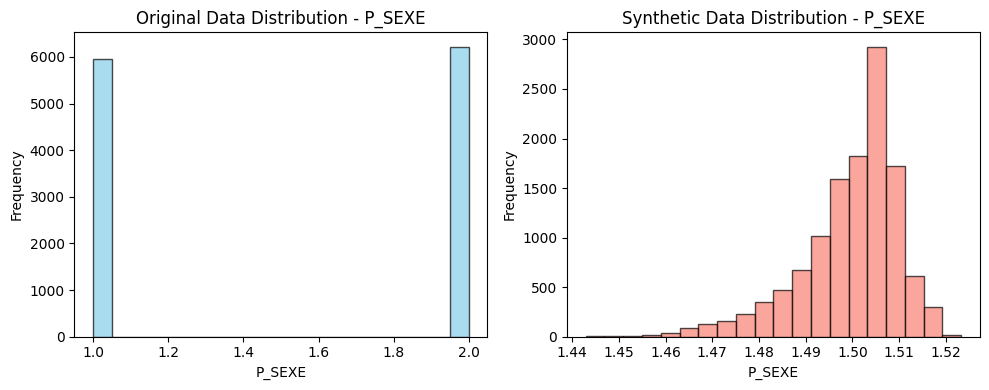

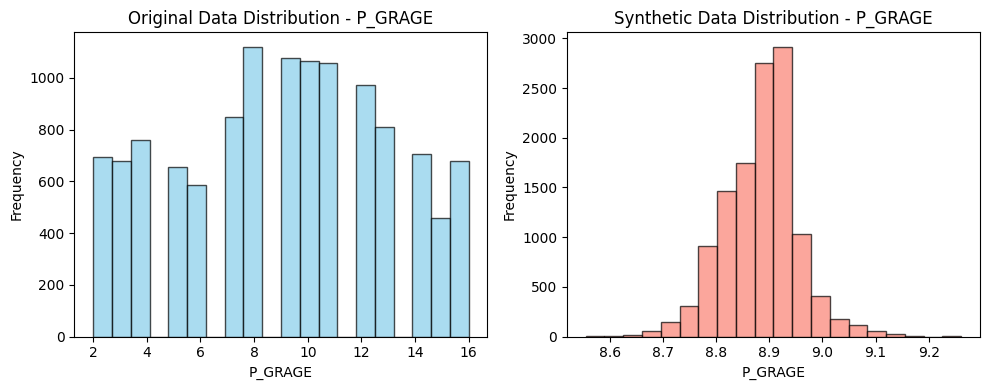

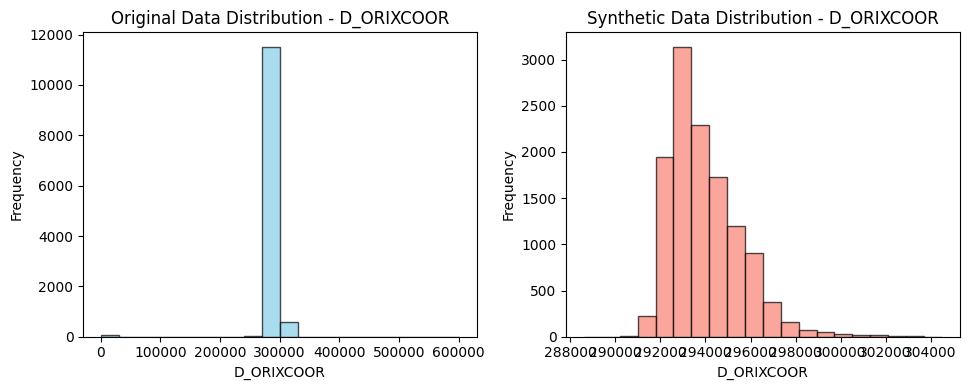

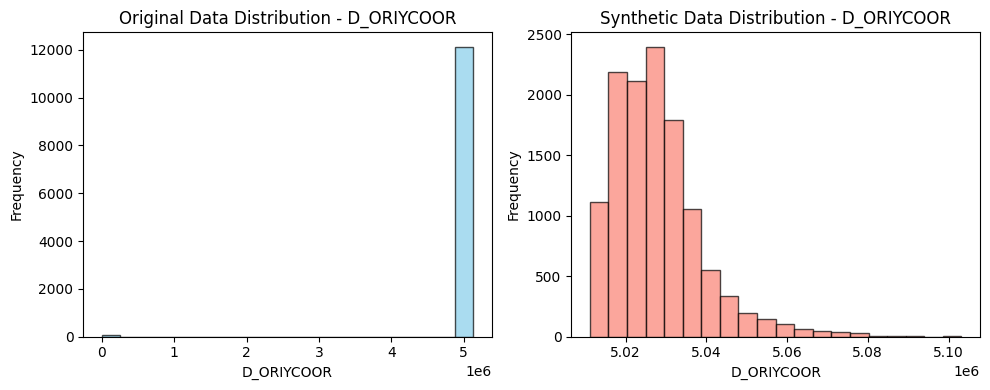

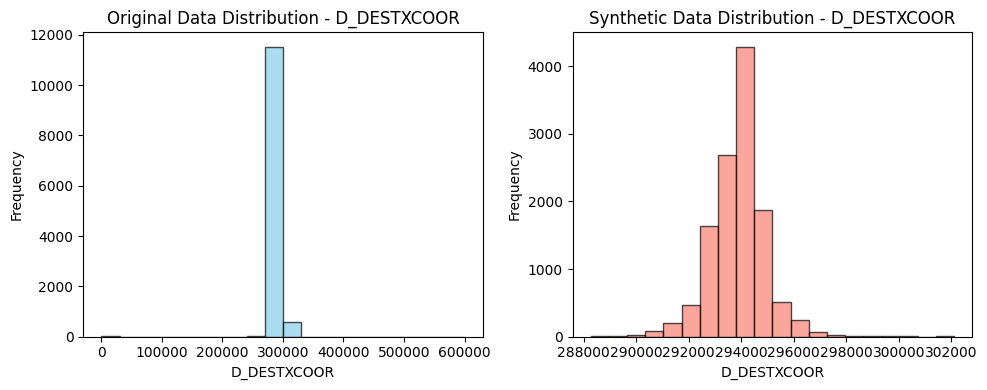

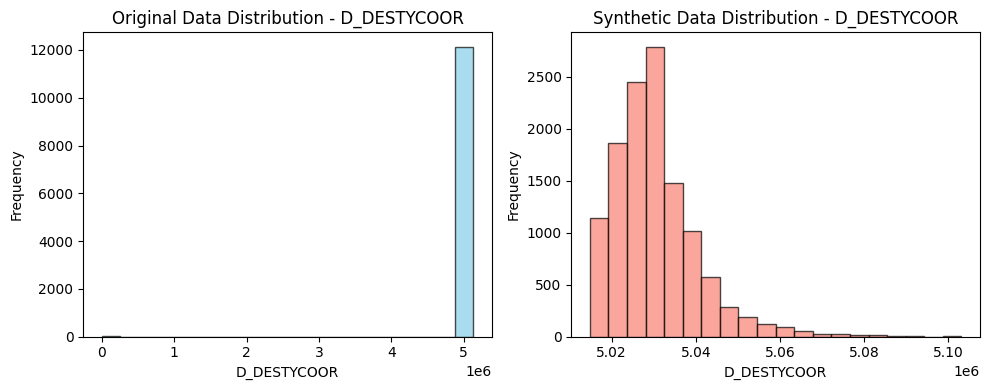

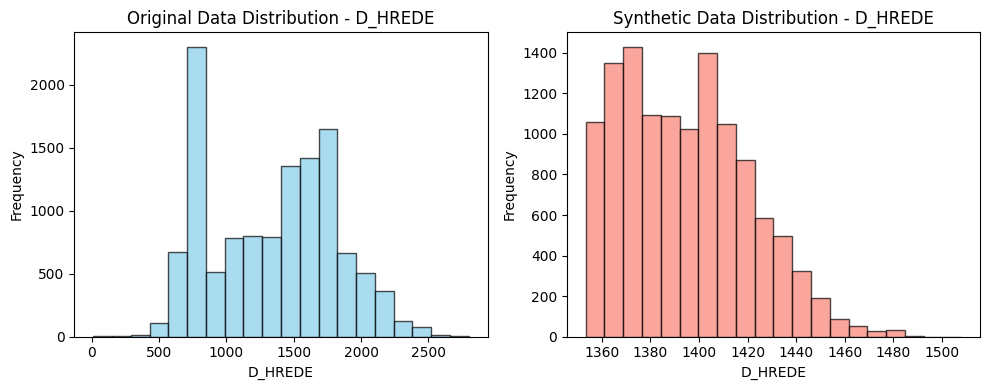

In [8]:
# Cell 7: Plot frequency distribution comparison between original and synthetic data
import matplotlib.pyplot as plt

print("Comparing frequency distributions of original and synthetic data:")

for col in data.columns:
    plt.figure(figsize=(10, 4))
    
    # Original data distribution
    plt.subplot(1, 2, 1)
    if pd.api.types.is_numeric_dtype(data[col]):
        data[col].plot(kind='hist', bins=20, color='skyblue', alpha=0.7, edgecolor='black')
    else:
        data[col].value_counts(normalize=True).sort_index().plot(kind='bar', color='skyblue')
    plt.title(f"Original Data Distribution - {col}")
    plt.xlabel(col)
    plt.ylabel('Frequency')
    
    # Synthetic data distribution
    plt.subplot(1, 2, 2)
    if pd.api.types.is_numeric_dtype(synthetic_data[col]):
        synthetic_data[col].plot(kind='hist', bins=20, color='salmon', alpha=0.7, edgecolor='black')
    else:
        synthetic_data[col].value_counts(normalize=True).sort_index().plot(kind='bar', color='salmon')
    plt.title(f"Synthetic Data Distribution - {col}")
    plt.xlabel(col)
    plt.ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()


In [9]:
# Cell 8: Enforce specific constraints on `P_SEXE` and `P_GRAGE` columns in synthetic data

# Enforce P_SEXE to be exactly 1 or 2
if 'P_SEXE' in synthetic_data.columns:
    synthetic_data['P_SEXE'] = np.where(synthetic_data['P_SEXE'] < 1.5, 1, 2)

# Ensure P_GRAGE contains only integer values
if 'P_GRAGE' in synthetic_data.columns:
    synthetic_data['P_GRAGE'] = np.round(synthetic_data['P_GRAGE']).astype(int)

# Display the updated unique values and sample data for verification
print("Unique values in 'P_SEXE' after correction:", synthetic_data['P_SEXE'].unique())
print("Unique values in 'P_GRAGE' after correction:", synthetic_data['P_GRAGE'].unique())
print("Sample corrected synthetic data:")
display(synthetic_data[['P_SEXE', 'P_GRAGE']].head())


Unique values in 'P_SEXE' after correction: [2 1]
Unique values in 'P_GRAGE' after correction: [9]
Sample corrected synthetic data:


,P_SEXE,P_GRAGE
0,2,9
1,2,9
2,2,9
3,2,9
4,2,9


In [10]:
# Save the final corrected synthetic data to a CSV file
output_file_path = r'C:\Users\TanMeh\Desktop\jupyter\corrected_synthetic_data.csv'
synthetic_data.to_csv(output_file_path, index=False)
print(f"Synthetic data has been saved to '{output_file_path}'")


Synthetic data has been saved to 'C:\Users\TanMeh\Desktop\jupyter\corrected_synthetic_data.csv'


Comparing frequency distributions of original and synthetic data:


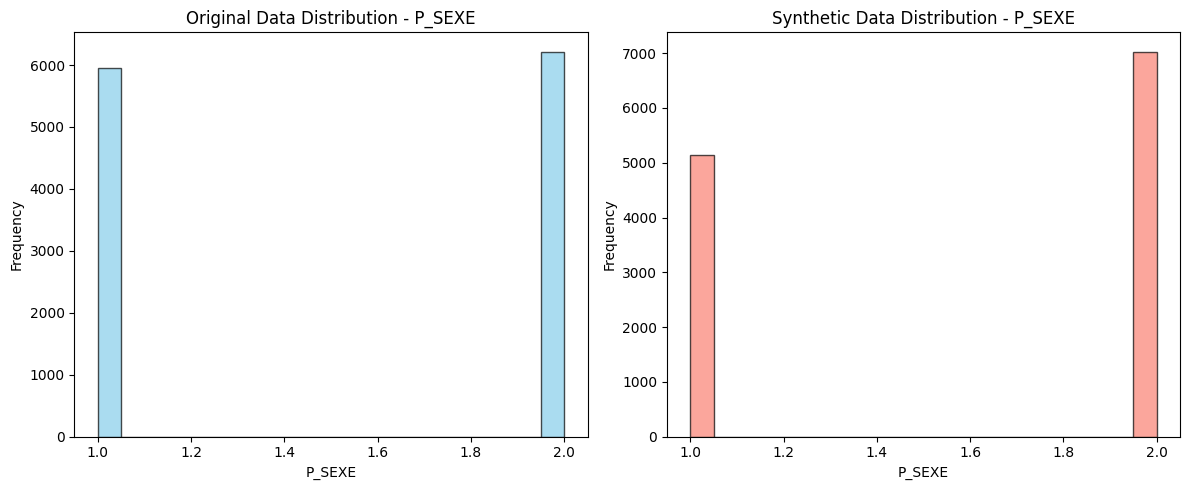

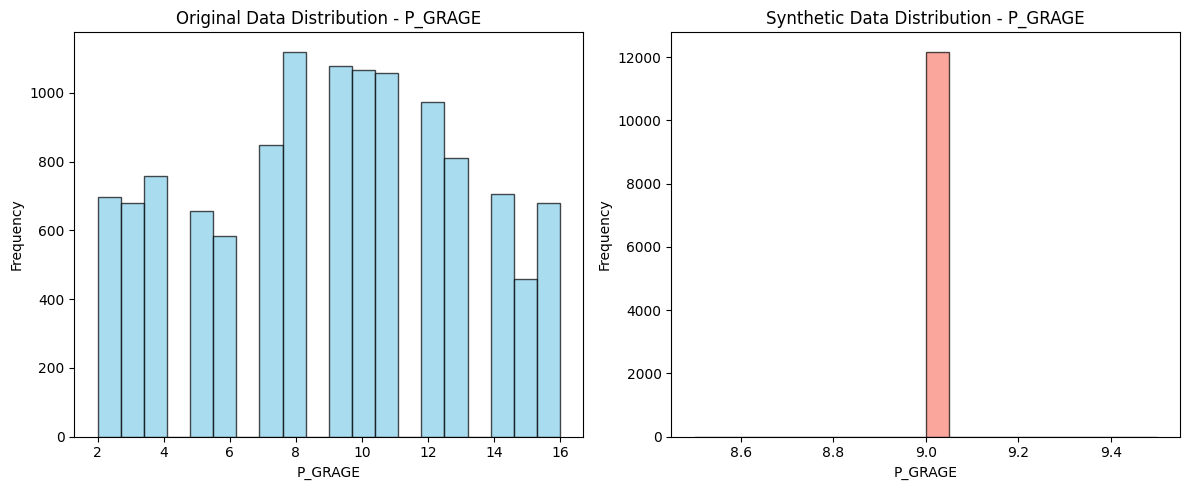

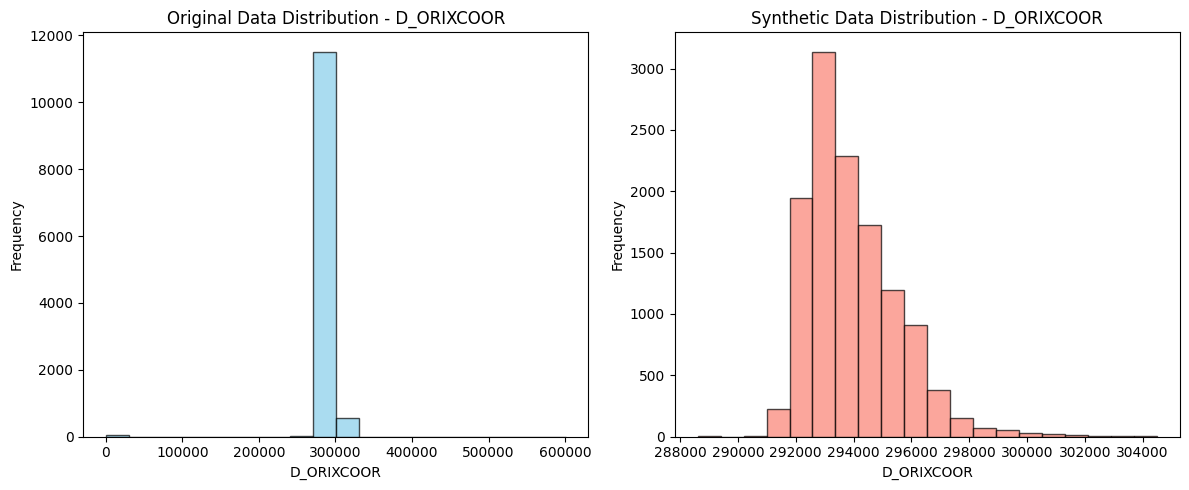

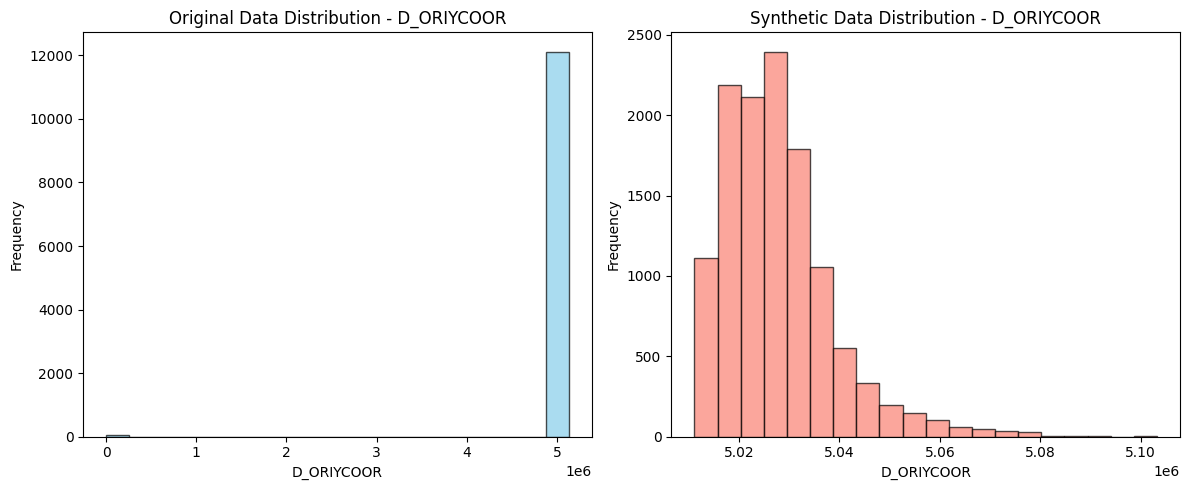

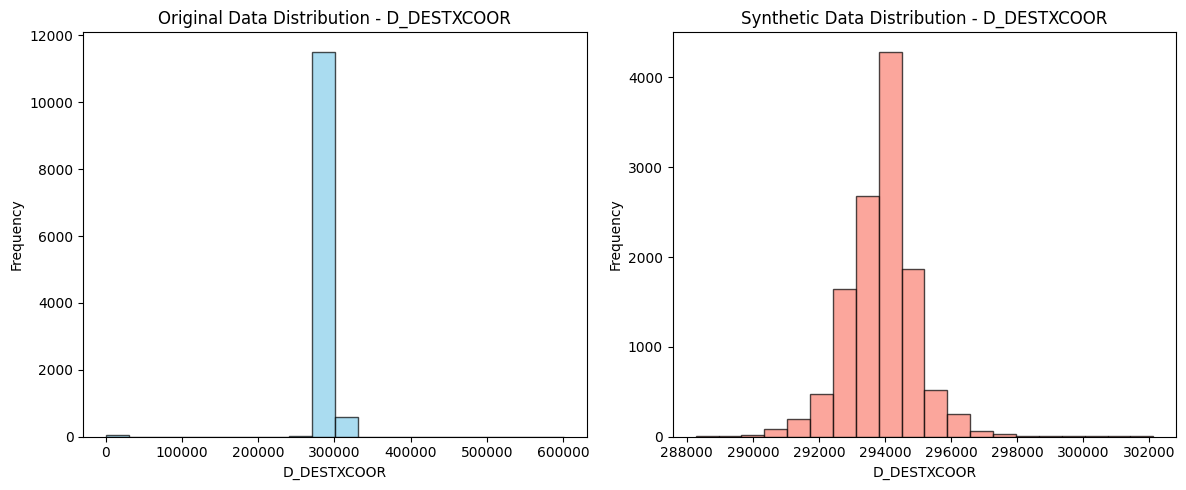

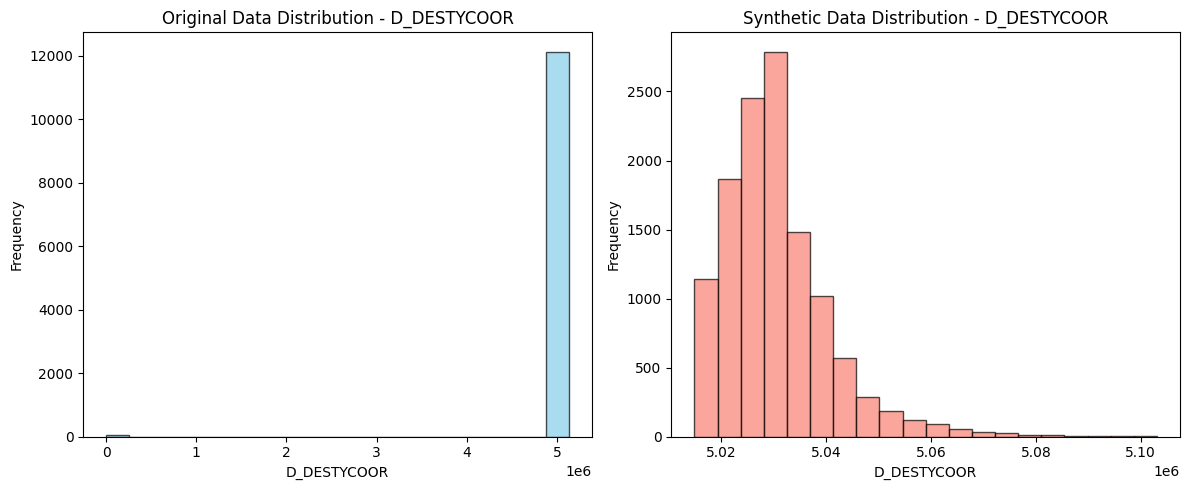

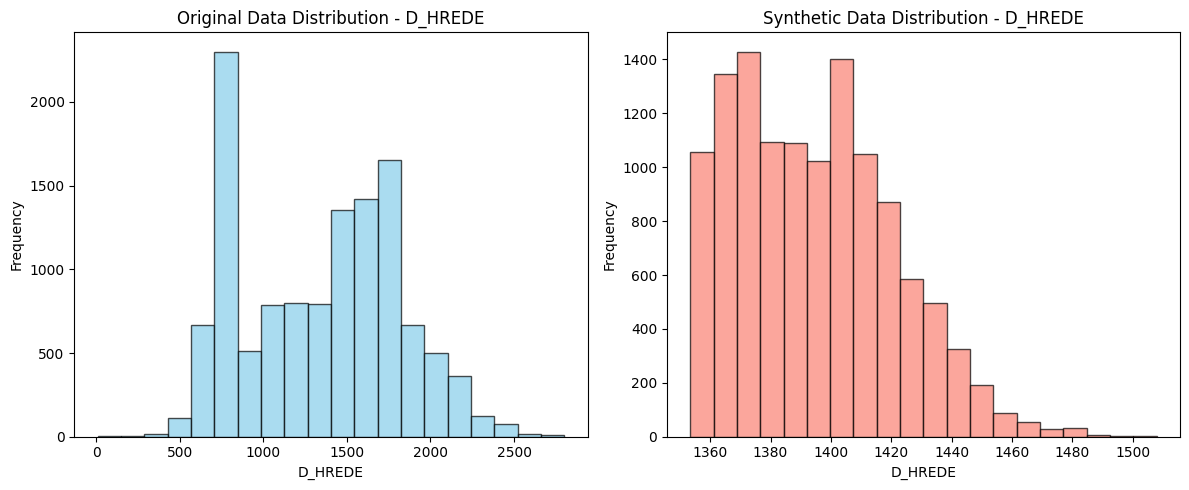

In [11]:
# Cell: Visualize and compare frequency distribution of original vs synthetic data
import matplotlib.pyplot as plt

print("Comparing frequency distributions of original and synthetic data:")

# Loop through each column to create side-by-side comparisons
for col in data.columns:
    plt.figure(figsize=(12, 5))
    
    # Original data distribution
    plt.subplot(1, 2, 1)
    if pd.api.types.is_numeric_dtype(data[col]):
        data[col].plot(kind='hist', bins=20, color='skyblue', alpha=0.7, edgecolor='black')
    else:
        data[col].value_counts(normalize=True).sort_index().plot(kind='bar', color='skyblue')
    plt.title(f"Original Data Distribution - {col}")
    plt.xlabel(col)
    plt.ylabel('Frequency')
    
    # Synthetic data distribution
    plt.subplot(1, 2, 2)
    if pd.api.types.is_numeric_dtype(synthetic_data[col]):
        synthetic_data[col].plot(kind='hist', bins=20, color='salmon', alpha=0.7, edgecolor='black')
    else:
        synthetic_data[col].value_counts(normalize=True).sort_index().plot(kind='bar', color='salmon')
    plt.title(f"Synthetic Data Distribution - {col}")
    plt.xlabel(col)
    plt.ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()
